# AWS DevDay Seoul 2019
## 모두를 위한 컴퓨터 비전 딥러닝 툴킷, GluonCV 따라하기
## Lab 2.2 Transfer Learning 적용하기

<!-- This notebook is based on: https://github.com/zhreshold/ICCV19-GluonCV -->

노트북을 처음 로딩할 때, Kernel로 **conda_mxnet_p36** 을 선택합니다.

### 랩 순서

1. Image Classification
2. Object Detection - SSD
3. Object Detection - YOLOv3

#### GluonCV와 필요한 python 패키지를 설치합니다.
GluonCV의 model_zoo와 utils 패키지에 대해서는 아래 링크를 참조하세요.
- model_zoo: [https://gluon-cv.mxnet.io/model_zoo/index.html](https://gluon-cv.mxnet.io/model_zoo/index.html)
- utils: [https://gluon-cv.mxnet.io/api/utils.html](https://gluon-cv.mxnet.io/api/utils.html)

In [1]:
# 최초 실행시 GPU(p2/p3) instance에서는 아래 코드로 gluoncv 패키지를 설치하세요.
!pip install --upgrade mxnet-cu100mkl gluoncv
# CPU(c4/c5/m4/m5/t2/t3) instance에서는 아래 코드로 gluoncv 패키지를 설치하세요.
#!pip install --upgrade mxnet-mkl gluoncv

Requirement already up-to-date: mxnet-cu100mkl in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (1.5.0)
Requirement already up-to-date: gluoncv in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (0.5.0)
Requirement not upgraded as not directly required: requests<3,>=2.20.0 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu100mkl) (2.20.0)
Requirement not upgraded as not directly required: numpy<2.0.0,>1.16.0 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu100mkl) (1.17.2)
Requirement not upgraded as not directly required: graphviz<0.9.0,>=0.8.1 in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu100mkl) (0.8.4)
Requirement not upgraded as not directly required: tqdm in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from gluoncv) (4.35.0)
Requirement not upgraded as not directly required: scipy in /home/ec2-user/anaconda

In [2]:
import os, time, shutil, zipfile
import matplotlib.pyplot as plt
import numpy as np

import mxnet as mx
from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import makedirs, download
from gluoncv.model_zoo import get_model

# Task 1 - Image Classification

## 여러분의 데이터셋을 사용해 Transfer Learning 적용하기

잘 아시는 `ImageNet`은 백만개 이상의 이미지로 구성되어 있지만, 다른 도메인에서는 그처럼 방대한 labeled dataset을 구하기 쉽지 않습니다.
Transfer learning은 바로 그럴 때 사용할 수 있는 테크닉으로, pretrained 모델의 학습 정보를 여러분의 도메인으로 옮겨오는 방법입니다.

## 데이터 준비

이번 랩에서는 `MINC-2500`이라는 데이터셋을 사용합니다. `MINC-2500`은 Cornell 대학교의 [MINC](http://opensurfaces.cs.cornell.edu/publications/minc/) 데이터셋의 부분집합으로, class당 2500개의 이미지, 총 23개의 class를 가지고 있습니다.

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png "MINC-2500 sample images")


아래 코드를 실행하면, 실습을 위해 미리 준비된 `MINC-2500`의 일부를 다운로드 받아 사용할 수 있습니다.

In [3]:
file_url = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/minc-2500-tiny.zip'
zip_file = download(file_url, path='./')
with zipfile.ZipFile(zip_file, 'r') as zin:
    zin.extractall(os.path.expanduser('./'))

다음으로, 각종 하이퍼파라미터를 설정합니다.

## 하이퍼파라미터

In [4]:
classes = 23

epochs = 5
lr = 0.001
per_device_batch_size = 1
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

#주의: CPU instance를 사용한다면 num_gpus를 0으로 설정하세요.
num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

Things to keep in mind:

1. `epochs = 5` 부분은 이번 랩에서 작은 데이터셋을 사용하기 때문입니다. 큰 데이터셋을 사용한다면 이 값을 늘리세요(예: 40).

2. `per_device_batch_size`도 역시 작게 지정되어 있습니다. 큰 데이터셋을 사용한다면 이 값도 늘려보시기 바랍니다(예: 64).

3. `num_gpus`와 `num_workers` 값은 여러분이 사용하는 인스턴스의 종류에 따라 적절히 설정하세요.

4. pretrained 모델이 이미 잘 만들어져 있으므로, 작은 `lr` 값으로 시작할 수 있습니다.

## Data Augmentation

다음은 transformation이라고도 하는 전처리 단계입니다. Transfer learning을 적용할 때 이 단계를 기본 모델과 동일하게 만드는 것이 중요합니다. 

아래 코드에서는 `ImageNet`과 동일한 전처리 과정을 사용합니다.

In [5]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    # from HWC to CHW
    transforms.ToTensor(), 
    # set mean and std
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

transform_test = transforms.Compose([
    transforms.Resize(256, keep_ratio=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

이제 데이터를 `train`, `validation`, `test`로 로드합니다.

`validation`과 `test`에도 동일한 전처리 과정을 사용합니다.

In [6]:
# 데이터셋 경로: 전체 데이터셋 또는 다른 데이터셋을 사용한다면 이 부분을 수정하세요.
path = './minc-2500-tiny'

train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

이제 데이터가 준비되었습니다.

## 모델 정의와 학습

이번 랩에서는 pretrained 모델로 `MobileNet1.0`을 사용하겠습니다.

In [7]:
model_name = 'MobileNet1.0'
# 다른 모델을 사용할 수도 있습니다.
#model_name = 'ResNet50_v2'

Transfer learning을 위해 새로운 모델(타겟 모델)을 아래와 같이 정의합니다.

1. Pretrained 모델을 로드한다. (예: `ImageNet` 데이터셋으로 학습한 `MobileNet1.0`)
2. 타겟 데이터셋(`MINC-2500`)의 클래스 수와 동일한 출력 크기를 가지는 새로운 output layer를 만들고, 이 layer의 파라미터를 랜덤 초기화한다.
3. 타겟 데이터셋으로 위의 모델을 학습시킨다.

이처럼 다른 task를 위해 학습된 모델을 새로운 dataset을 위해 tune하는 것을 **fine-tuning**이라고 부릅니다.

![alt text](https://www.d2l.ai/_images/finetune.svg "Fine tuning")


In [8]:
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
# convert execution style into symbolic programming
finetune_net.hybridize()

# Trainer, metric, loss
trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

다음으로, `validation`과 `test` 데이터셋의 성능을 평가할 함수를 정의합니다.

In [9]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

## 학습 루프

이제 학습을 시작할 수 있습니다. 

`epochs` 하이퍼파라미터 값을 늘리거나, 더 큰 데이터셋을 사용하면 정확도를 더 높일 수 있습니다.

In [10]:
lr_counter = 0
num_batch = len(train_data)

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(finetune_net, val_data, ctx)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.052, loss: 3.385 | Val-acc: 0.000 | time: 2.9
[Epoch 1] Train-acc: 0.026, loss: 3.428 | Val-acc: 0.000 | time: 1.6
[Epoch 2] Train-acc: 0.035, loss: 3.243 | Val-acc: 0.000 | time: 1.6
[Epoch 3] Train-acc: 0.043, loss: 3.235 | Val-acc: 0.087 | time: 1.5
[Epoch 4] Train-acc: 0.035, loss: 3.165 | Val-acc: 0.043 | time: 1.5
[Finished] Test-acc: 0.043


지금까지 간단한 예제로 image classification 모델의 transfer learning 과정을 배워봤습니다. 더 자세한 내용을 알고 싶으시면 `GluonCV`의 [관련 문서](https://gluon-cv.mxnet.io/build/examples_classification/transfer_learning_minc.html)를 방문해 보시기 바랍니다.


# Task 2 - Object Detection - SSD


## 커스텀 데이터셋을 사용해 Transfer Learning 적용하기

Object detection에도 transfer learning을 적용할 수 있습니다. 
Pikachu 데이터셋이라는 커스텀 데이터셋을 pretrained 모델에 학습시켜 피카추를 detection하는 예제를 실행해보겠습니다.

## Pikachu 데이터셋

Pikachu 데이터셋에 대해서는 이 [링크](https://www.d2l.ai/chapter_computer-vision/object-detection-dataset.html)를 참고하시기 바랍니다.

![alt text](https://www.d2l.ai/_images/output_object-detection-dataset_42a473_7_0.png "Pikachu dataset")

먼저 데이터셋을 다운로드합니다. 


In [11]:
import time
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon, nd, image
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import download, viz
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

In [12]:
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='pikachu_train.rec', overwrite=False)
download(idx_url, path='pikachu_train.idx', overwrite=False)

'pikachu_train.idx'

다운로드한 데이터셋을 로드해서 확인합니다.

label: [[214.70685 132.91504 271.07706 215.32448   0.     ]]


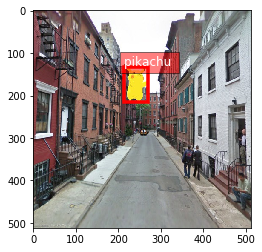

In [13]:
dataset = gluoncv.data.RecordFileDetection('pikachu_train.rec')
classes = ['pikachu']  # only one foreground class here
image, label = dataset[1]
print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

이 데이터셋은 오픈소스 3D 피카추 모델로부터 생성한 1000개의 다양한 피카추 이미지를 여러 풍경사진 배경 위에 합성한 것입니다.

Pretrained `ssd_512_mobilenet1.0_voc` 모델을 로드해서 output layer를 리셋합니다.

## Pre-trained 모델

먼저, 여러 object detection 모델 중에서 `SSD`를 사용해보겠습니다. 빠른 실행을 위해 `MobileNet1.0`을 기본으로 하는 `SSD`를 선택합니다.

`GluonCV Model Zoo`가 지원하는 detection 모델의 전체 목록은 [Model Zoo > Detection](https://gluon-cv.mxnet.io/model_zoo/detection.html) 링크에서 확인할 수 있습니다.

In [14]:
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Pikachu detection을 위해 output layer를 리셋합니다.

In [15]:
net.reset_class(classes)
# now the output layers that used to map to VOC classes are now reset to distinguish pikachu (and background).

Pretrained weight로부터 커스텀 네트웍을 쉽게 만들 수 있는 API가 있습니다. 위의 두 줄(pretrained 모델을 로드하고 `net.reset_class`를 호출하는) 코드와 아래의 코드는 동일한 기능을 합니다.

```python
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes,
    pretrained_base=False, transfer='voc')
```

## Fine-tuning은 학습의 새로운 단계

이제 dataloader를 아래 코드와 같이 정의합니다.




In [16]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 16, 0)


학습에 가능하면 GPU를 사용할 것을 권해드립니다.


In [17]:
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]
net.collect_params().reset_ctx(ctx)


다음으로 trainer, loss와 metric을 정의합니다.



In [18]:
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
mbox_loss = gluoncv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')


모든 것이 준비되었으므로 이제 학습을 시작할 수 있습니다. 이 데이터셋에는 2번의 epoch면 충분합니다.


In [19]:
for epoch in range(0, 2):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        # since we have already normalized the loss, we don't want to normalize
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 1 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()

[Epoch 0][Batch 0], Speed: 3.081 samples/sec, CrossEntropy=8.189, SmoothL1=1.808
[Epoch 0][Batch 1], Speed: 17.349 samples/sec, CrossEntropy=7.303, SmoothL1=1.942
[Epoch 0][Batch 2], Speed: 15.890 samples/sec, CrossEntropy=6.672, SmoothL1=1.840
[Epoch 0][Batch 3], Speed: 14.791 samples/sec, CrossEntropy=6.212, SmoothL1=1.858
[Epoch 0][Batch 4], Speed: 16.293 samples/sec, CrossEntropy=5.848, SmoothL1=1.845
[Epoch 0][Batch 5], Speed: 14.077 samples/sec, CrossEntropy=5.556, SmoothL1=1.944
[Epoch 0][Batch 6], Speed: 17.481 samples/sec, CrossEntropy=5.345, SmoothL1=1.835
[Epoch 0][Batch 7], Speed: 16.633 samples/sec, CrossEntropy=5.145, SmoothL1=1.751
[Epoch 0][Batch 8], Speed: 18.350 samples/sec, CrossEntropy=4.985, SmoothL1=1.651
[Epoch 0][Batch 9], Speed: 14.275 samples/sec, CrossEntropy=4.835, SmoothL1=1.644
[Epoch 0][Batch 10], Speed: 16.182 samples/sec, CrossEntropy=4.700, SmoothL1=1.565
[Epoch 0][Batch 11], Speed: 11.385 samples/sec, CrossEntropy=4.584, SmoothL1=1.601
[Epoch 0][Batch

[Epoch 1][Batch 43], Speed: 17.698 samples/sec, CrossEntropy=1.525, SmoothL1=0.439
[Epoch 1][Batch 44], Speed: 14.027 samples/sec, CrossEntropy=1.522, SmoothL1=0.442
[Epoch 1][Batch 45], Speed: 15.843 samples/sec, CrossEntropy=1.521, SmoothL1=0.447
[Epoch 1][Batch 46], Speed: 14.155 samples/sec, CrossEntropy=1.520, SmoothL1=0.446
[Epoch 1][Batch 47], Speed: 16.212 samples/sec, CrossEntropy=1.522, SmoothL1=0.444
[Epoch 1][Batch 48], Speed: 15.661 samples/sec, CrossEntropy=1.519, SmoothL1=0.443
[Epoch 1][Batch 49], Speed: 15.014 samples/sec, CrossEntropy=1.514, SmoothL1=0.446
[Epoch 1][Batch 50], Speed: 13.585 samples/sec, CrossEntropy=1.515, SmoothL1=0.450
[Epoch 1][Batch 51], Speed: 17.364 samples/sec, CrossEntropy=1.510, SmoothL1=0.447
[Epoch 1][Batch 52], Speed: 16.543 samples/sec, CrossEntropy=1.501, SmoothL1=0.442
[Epoch 1][Batch 53], Speed: 18.467 samples/sec, CrossEntropy=1.500, SmoothL1=0.442
[Epoch 1][Batch 54], Speed: 17.560 samples/sec, CrossEntropy=1.499, SmoothL1=0.443
[Epo

Fine-tuning의 결과로 얻은 weight 값을 디스크에 저장합니다.

In [20]:
net.save_parameters('ssd_512_mobilenet1.0_pikachu.params')


## Fine-tuning한 모델로 예측하기

위에서 fine-tuning한 weight로 성능을 테스트할 수 있습니다. 여러 피카추가 들어있는 테스트 이미지로, 과연 모두 찾을 수 있을지 확인해 보겠습니다.


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


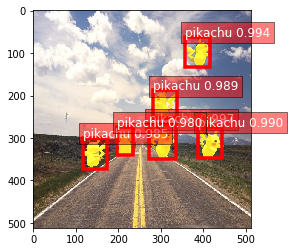

In [21]:
test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
download(test_url, 'pikachu_test.jpg')
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_pikachu.params')
x, image = gluoncv.data.transforms.presets.ssd.load_test('pikachu_test.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()

5분도 걸리지 않은 두 번의 epoch만으로도 모든 피카추를 찾을 수 있었습니다.

